# <center>ECHO Drone Switching Regulator RFI Study</center>

#### <center>Mickey Horn | June 14, 2019</center>
<center>*The goal of this memo is to examine and describe the RFI from the switching regulator on the X8 drone that was discovered during the Owens Valley LWA field trip in order to confirm that it is the source of the RFI. This memo will also perform the same study on the Power Brick Mini that came with our Pixhawk 2.1 and will go on the Chiropter, the next generation ECHO drone. This will allow us to determine if we need extra shielding or isolation on the Power Brick Mini to reduce the amount of RFI coming from the Chiropter.*</center>

## Different Types of RFI
There are three possible types of RFI that the switching regulators could be emitting: direct radiation, wire radiation, and dirty power. Direct radiation comes off of the board itself, while wire radiation comes off of any of the 10 wires. These two types of RFI require a probe and spectrum analyzer to examine, and are not currently a part of this study (but may be added later). Instead, this memo will focus on dirty power, which is just the direct output of the +5V line leading into the Pixhawk.

## X8 Switching Regulator <img src="X8_reg.jpg" alt="X8 Regulator" width="200" height="100" align="right" />
The X8 drone that was exhibiting RFI at Owens Valley uses the switching regulator pictured to the right. On the top right is an XT60 connector (V+ and ground wires), which connects directly to the drone's LiPo battery. The top left are V+ and ground wires that lead into the power distribution board (PDB), and in turn to the ESCs and motors. The bottom is a 6pin connector that runs into the POWER port on the Pixhawk. Pins 1 and 2 are +5V, 3 is current data, 4 is voltage data, and 5 and 6 are ground.

## Power Brick Mini <img src="pbm_reg.jpg" alt="PBM Regulator" width="225" height="150" align="right" />
The Power Brick Mini (PBM) is a more recent model of the switching regulator on the X8. It comes packaged with the Pixhawk 2.1 that we are planning on using for the Chiropter. It has identical input and outputs to the X8's regulator, but is more compact and doesn't include any V+ and ground wires to the XT60 connectors. The 6pin connector is hidden from view and currently has no wires, but is identical to the X8 regulator's 6pin.

## Method 
In order to examine this dirty power RFI, we need to hook up the switching regulators to a power source and an oscilloscope, as shown in the pictures below. A DC power supply is clipped on to the input XT60 connector. It is configured to deliver 14.8V (equivalent to a 4S battery) at no more than 0.5A. The current stayed constant at approximately 0.02A, which is lower than what would be delivered during flight, but also should have little or no effect on our data. I believe this current limitation is from the wires used to clip on to the XT60 connector. The oscilloscope probe is then connected to one of the +5V wires and one of the ground wires from the 6pin connector. The results are identical for any combination of the 4 wires and are discussed in the sections below. 

<img src="X8_reg_setup.jpg" alt="X8 Setup" width="300" height="200" align="left" /><img src="X8_reg_setup_zoom.jpg" alt="X8 Setup Zoom" width="225" height="150" />

The Power Brick Mini was set up in a similar fashion, however some creativity had to be used to have the probes contact the wires because we did not want to cut off the connector.

<img src="pbm_reg_setup.jpg" alt="PBM Setup" width="300" height="200" align="left" /><img src="pbm_reg_setup_zoom.jpg" alt="PBM Setup Zoom" width="225" height="150" />

## X8 Results 
The picture to the right shows the oscilloscope results from the X8 regulator. As you can see on the <img src="X8_reg_rfi_fullpic.png" alt="X8 Oscope Picture" width="300" height="200" align="right" /> right hand side of the image, the signal is coming out at about +5V (with a 0.26V peak-to-peak) as it should be, and at a frequency of 53MHz. The RFI we experienced at Owens Valley was around 50MHz, so this matches what we'd expect. However, to be confident in the frequency of the RFI, we need to perform a Fourier transform on the data from the oscilloscope in order to see the spectrum across the frequency domain. A USB flashdrive can be inserted into the oscilloscope, and the data is saved as a csv file. The code below takes the csv file and performs a Fourier transform on it. The following plot shows the spectrum for the X8 regulator. This regulator has a clear spike at 50MHz that flows about 25MHz to each side. This is consistent with our findings in the field at Owens Valley and shows that this switching regulator would need to be shielded and/or isolated for future flights, especially if we are measuring around 50MHz.

In [1]:
%matplotlib notebook
import pandas as pd
from scipy.fftpack import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# import X8 csv file
df = pd.read_csv('X8_reg_rfi_data_adj.csv')

# calc X8 FFT
v = np.array(df.iloc[::2,1]) # raw voltage data
t = np.array(df.iloc[::2,0]) # raw time data
v -= np.mean(v) # centered on 0V (because difference is small)
dt = np.diff(t)[0] # remove redundant times
vf = fft(v) # fft y-axis
tf = fftfreq(len(vf),dt) # fft x-axis

<IPython.core.display.Javascript object>


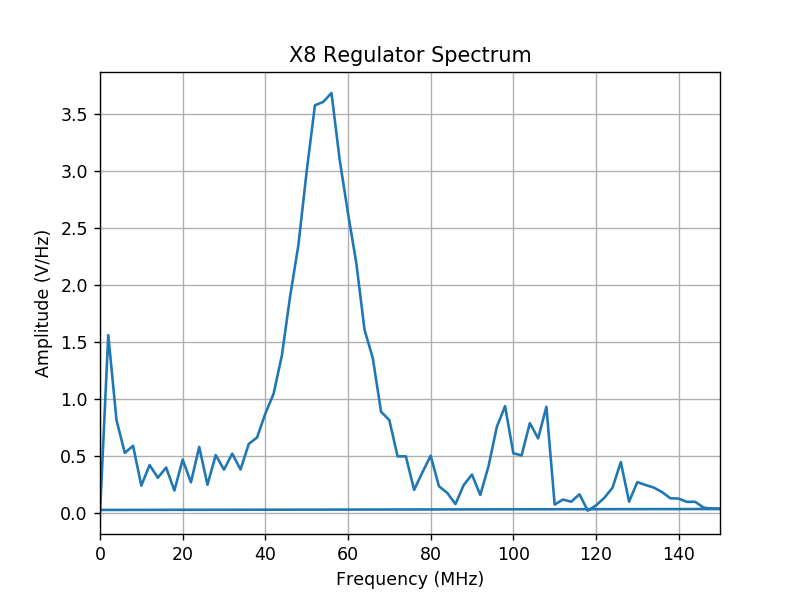

In [2]:
# X8 FFT plot
plt.figure()
plt.plot(tf/1e6,np.abs(vf))
plt.xlim(0,150)
plt.title('X8 Regulator Spectrum')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (V/Hz)')
plt.grid()

# PBM Results
The picture to the right shows the oscilloscope <img src="pbm_reg_rfi_fullpic.png" alt="PBM Oscope Picture" width="300" height="200" align="right" /> results of the Power Brick Mini that we are planning on using for the Chiropter. This signal also has an output voltage of +5V around 50MHz, similar to the X8 regulator. However, the peak-to-peak voltage is much smaller, at 68mV in this image and capping out around 115mV. This is about half as much as the X8 regulator. The image is also less clear than the X8 regulator, likely due to the poor contact between the probes and the connector. We may decide to snip the 6pin wires so that we can probe it identically to the X8 regulator at a later date. The plot below shows the spectra for the PBM. This spectrum is much different than the X8 regulator's spectrum. The peak amplitude is closer to 90 or 100MHz, and the amplitude around that peak is much flatter than the X8's spectrum. Figure 3 below shows the two spectra overlayed on top of each other for a quick comparison.

In [3]:
# import pbm csv file
df2 = pd.read_csv('pbm_reg_rfi_data_adj.csv')

# calc X8 FFT
v2 = np.array(df2.iloc[::2,1]) # raw voltage data
t2 = np.array(df2.iloc[::2,0]) # raw time data
v2 -= np.mean(v2) # centered on 0V (because difference is small)
dt2 = np.diff(t2)[0] # remove redundant times
vf2 = fft(v2) # fft y-axis
tf2 = fftfreq(len(vf2),dt2) # fft x-axis

<IPython.core.display.Javascript object>


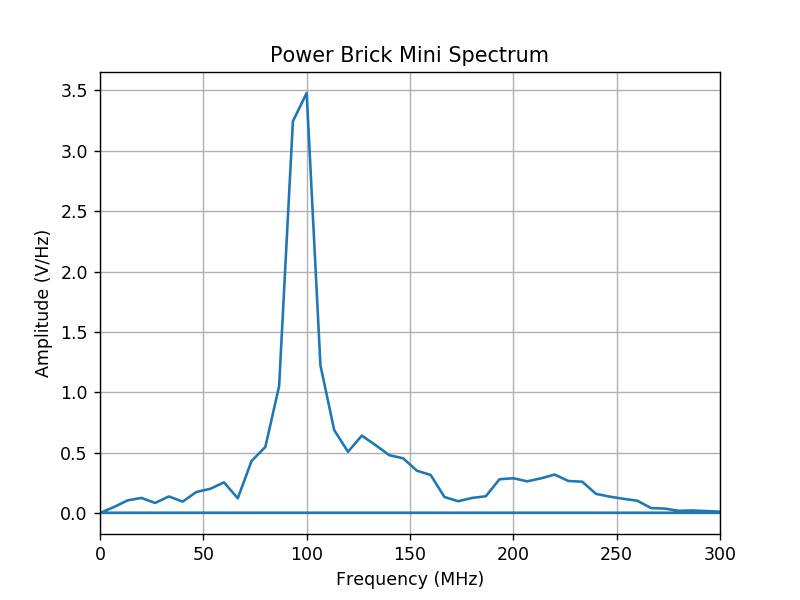

In [4]:
# pbm FFT plot
plt.figure()
plt.plot(tf2/1e6,np.abs(vf2))
plt.xlim(0,300)
plt.title('Power Brick Mini Spectrum')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (V/Hz)')
plt.grid()

<IPython.core.display.Javascript object>


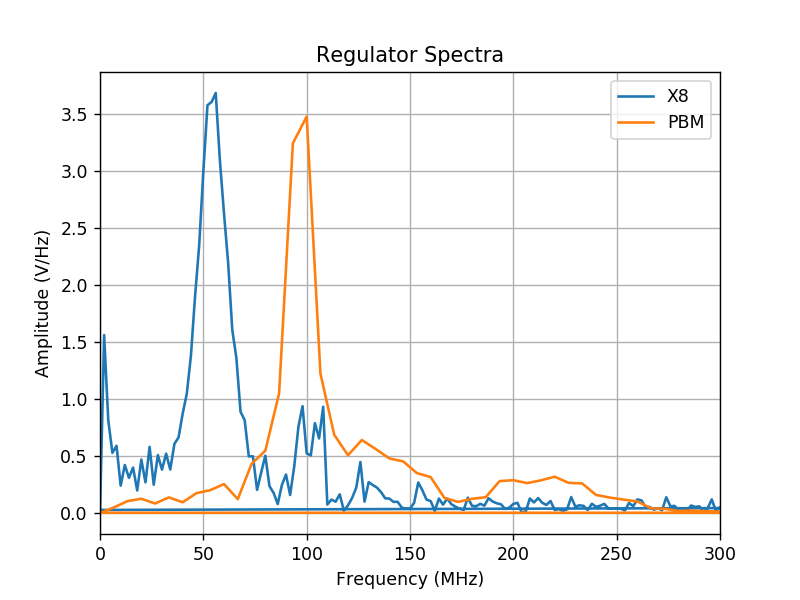

In [5]:
# overlayed spectra plot
plt.figure()
plt.plot(tf/1e6,np.abs(vf),label='X8')
plt.plot(tf2/1e6,np.abs(vf2),label='PBM')
plt.xlim(0,300)
plt.title('Regulator Spectra')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (V/Hz)')
plt.legend(loc='upper right')
plt.grid()

## Conclusion
Figure 3 shows that while the RFI of the PBM is still something for us to be concerned about. Although the signal is more constrained in frequency, it has a higher amplitude than the X8's spectrum and is closer to the desired frequency for HERA, one of ECHO's major calibration goals. We will likely need to isolate or shield the PBM during Chiropter construction, or try to find another switching regulator that has less prominent RFI.